Include all the necessary imports below.

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import *
from qiskit.visualization import plot_histogram
import math
import random

Define a function/method that converts a integer into a binary value. 

In [2]:
# val - number to be converted
# length - the number of bits for the binary value

def toBinary(val, length):
    binary = '' # declare an empty string
    loop = val

    if val == 0:
        binary = '0'
    else:
        while loop > 0:
            temp = loop % 2 # calculate the bit value
            loop = loop // 2
            binary += str(temp) # add the bit value to the bit string

    # If the binary value is shorter than the number of bits
    # passed, append 0's in front of the binary number equal
    # to the difference between the binary length and the total length .
    while len(binary) < length:
        binary += '0'
        
    binary = binary[::-1] # reverse the string
    return binary

# Only converts the value to binary, doesn't add extra 0's in front
# to match the number of required qubits.
def toBinary_only(val):
    binary = '' # declare an empty string
    loop = val

    while loop > 0:
        temp = loop % 2 # calculate the bit value
        loop = loop // 2
        binary += str(temp) # add the bit value to the bit string
    
    binary = binary[::-1] # reverse the string
    return binary

Generate the search index.

In [3]:
choice_list = []

# Define the length of the array, can be any length
array_length = 16

for i in range(array_length):
    choice_list.append(random.randint(0, 50))

print("Array/Database =",choice_list)

binary_length = toBinary_only(array_length)
qubits_needed = len(binary_length)

# Define a search index (less then array_length) of the list/array/database
search_index = 15
search_val = choice_list[search_index]

print("Search Value =",search_val)
print("Search Index =",search_index)

Array/Database = [17, 16, 43, 38, 35, 7, 13, 11, 32, 37, 4, 18, 11, 15, 6, 40]
Search Value = 40
Search Index = 15


Define an oracle to implement the search value in the circuit.

In [4]:
def oracle(circuit, n, val):

    binary_val = toBinary(val, n)
    binary_val = binary_val[::-1]

    # If the input value contains a qubit 0, apply an x gate to it
    # to switch it to a 1 to affect the axillary bit. 1100
    for i in range(len(binary_val)):
        if binary_val[i] == '0':
            circuit.x(i)

    ############ Implement the multi-control conditional gate ################ 
    circuit.ccx(0, 1, n) # Apply the toffoli gate to the first helper qubit.

    for i in range(2, n):
        circuit.ccx(i, i+(n-2), i+(n-1)) # Apply a toffoli gate from the second to the last (auxillary) gate.

    for i in range(n-2, 1, -1):
        circuit.ccx(i, i+(n-2), i+(n-1)) # Apply the reverse gates from the second helper qubit to the last helper qubit.

    circuit.ccx(0, 1, n) # Apply the toffoli gate to the first helper qubit.
    ##########################################################################

    # Repeat the same step to revert the qubit change from '1' to '0'.
    for i in range(len(binary_val)):
        if binary_val[i] == '0':
            circuit.x(i)
    
    return circuit

Define the defuser.

In [5]:
# The diffuser takes in a circuit that applies the appropriate gates.
def diffuser(circuit, n):

    # Apply the hadamard gate to the "n" address bits.
    for qubit in range(n):
        circuit.h(qubit)
        
    # Apply the flip gate to the "n" address bits.
    for qubit in range(n):
        circuit.x(qubit)

    # Apply the multi-control conditional gate to the circuit to change the auxillary bit.
    ########################################
    circuit.ccx(0, 1, n)
    
    for i in range(2, n):
        circuit.ccx(i, i+(n-2), i+(n-1))

    for i in range(n-2, 1, -1):
        circuit.ccx(i, i+(n-2), i+(n-1))

    circuit.ccx(0, 1, n)
    ########################################

    # Reverse the flip gate applied earlier.
    for qubit in range(n):
        circuit.x(qubit)

    # Reverse the hadamard gate applied earlier.
    for qubit in range(n):
        circuit.h(qubit)
    
    return circuit

Define the circuit with the address, helper, and auxillary qubits.

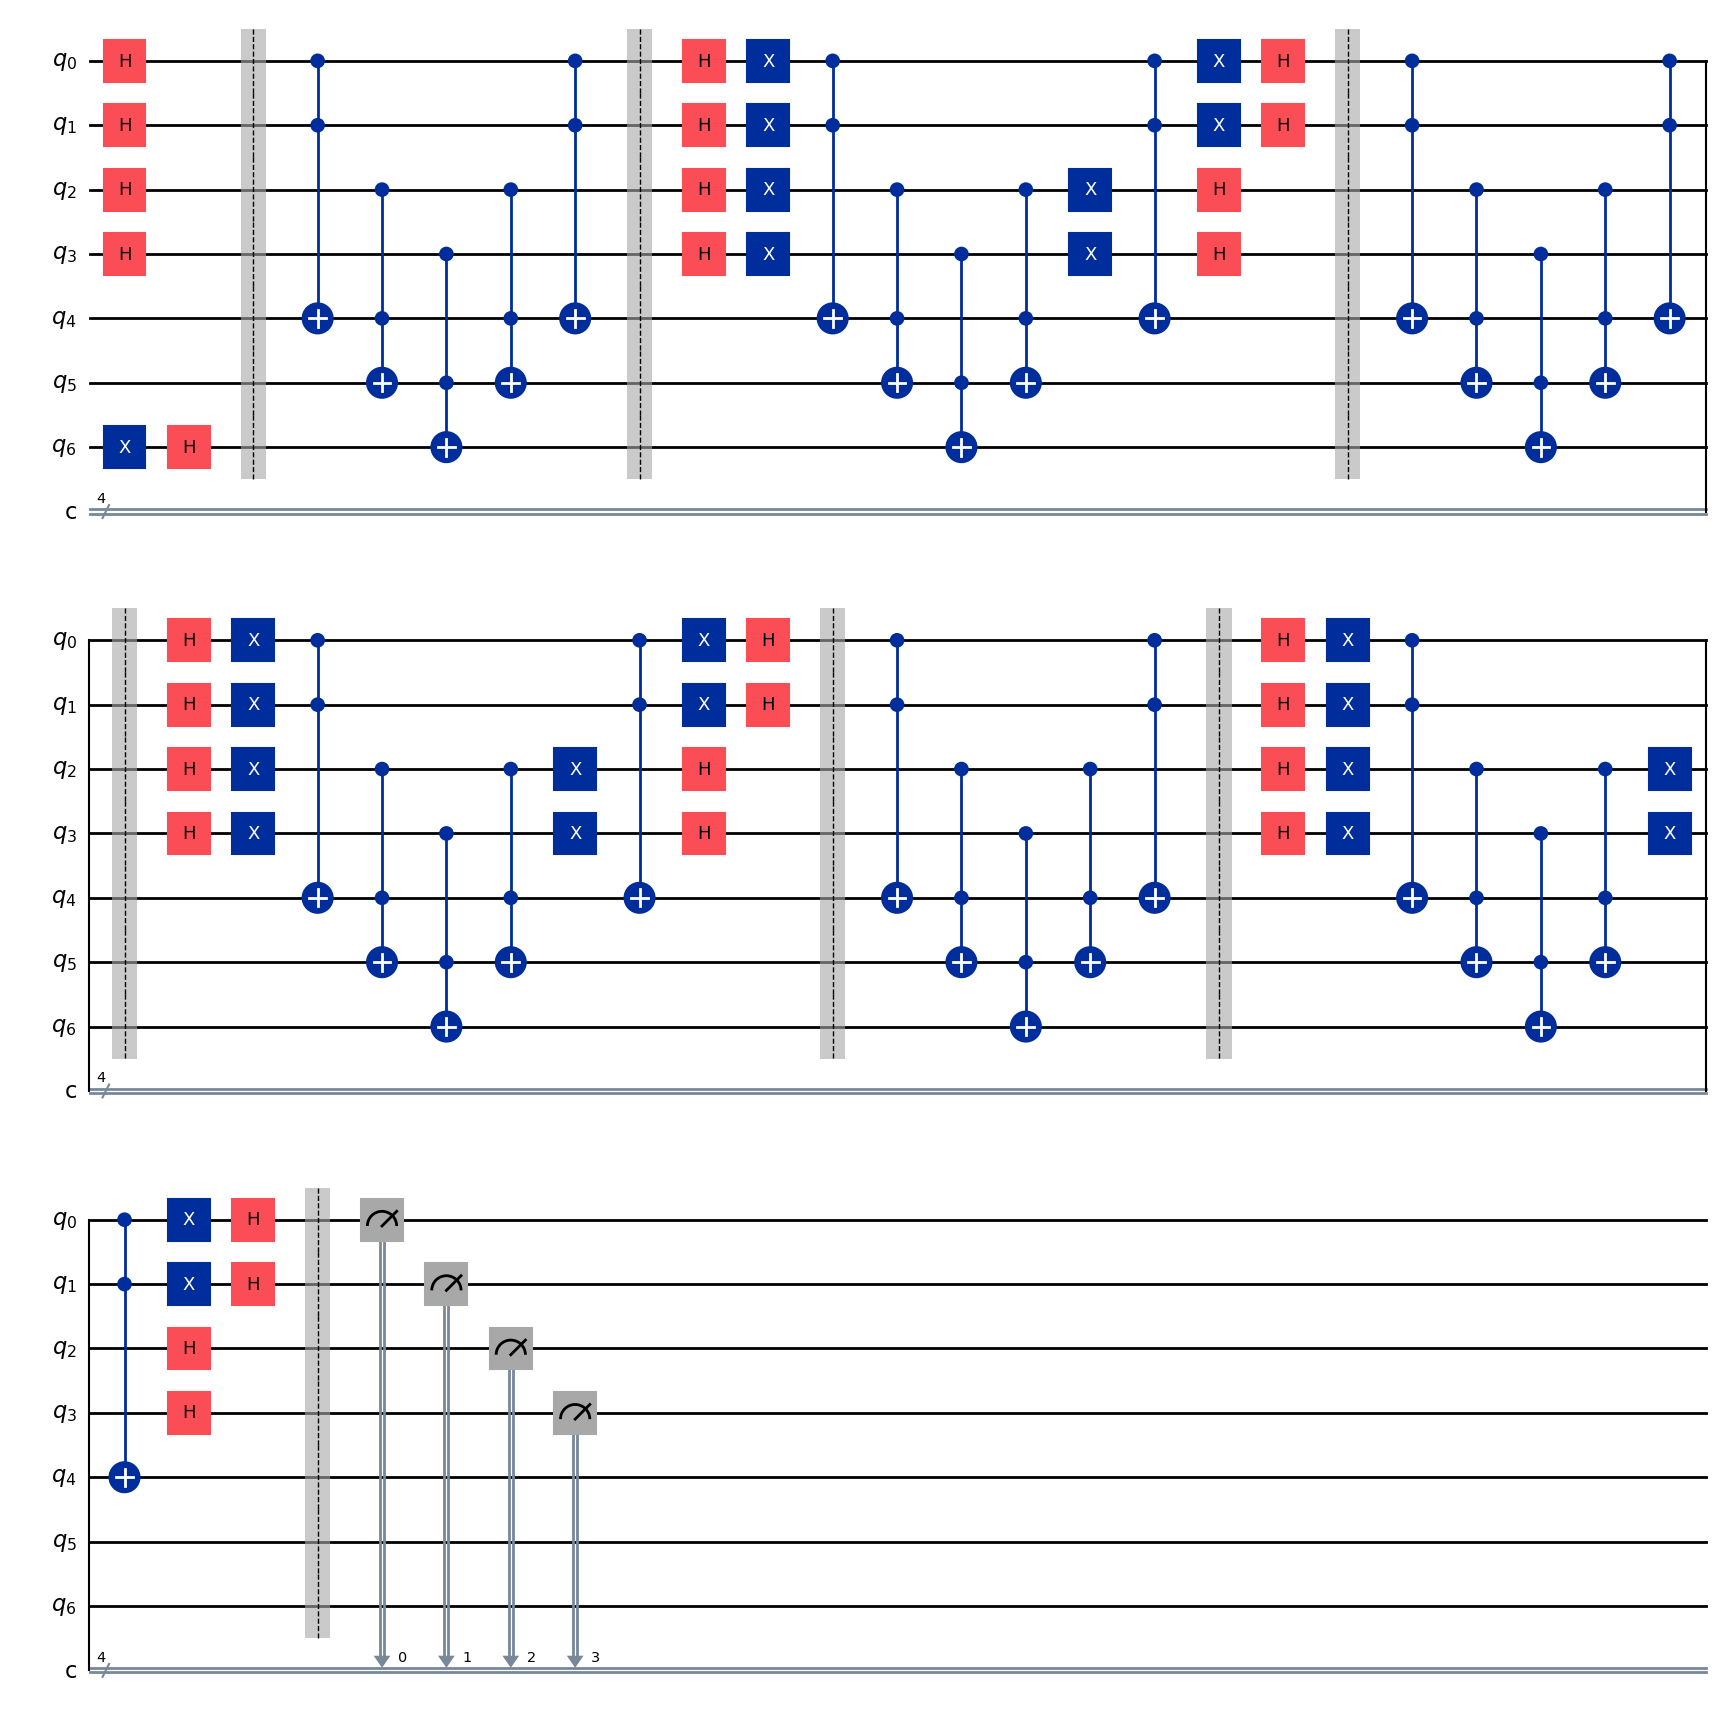

In [6]:
def ispower2(number):

    log_val = math.log(number, 2);
    pow_val = math.pow(2, round(log_val));
    return pow_val == number

# First "n" qubits will be allocated to the address qubits.
if ispower2(array_length):
    address_bit = qubits_needed - 1
else:
    address_bit = qubits_needed

helper_bits = address_bit - 2      # next "n-2" qubits will be used as helper qubits for the multi-control conditional gate.
auxillary_bit = 1                  # Last qubit will be reserved to the auxillary qubit.
qubits = address_bit + helper_bits + auxillary_bit # Find the total number of qubits needed to implement the circuit.

# Define the test value for the cirucit
test_value = search_index

qc = QuantumCircuit(qubits, address_bit)

# Initialise the address qubits and place them into a superposition.
for i in range(address_bit):
    qc.h(i)

# Place the auxillary qubit into the |-> state.
qc.x(qubits-1)
qc.h(qubits-1)

# Define the number of needed iterations for the search to occurr.
# The optimal value is equal to the square root of the number of values in the array/database.

iterations = int(address_bit**(1/2))+1 # The int() value rounds down the number of iterations, thus we add 1 to the number of iterations. 

# Apply the number of Oracle-Diffusor pair equal to the number of iterations.
for i in range(iterations):
    qc.barrier()
    oracle(qc, address_bit, test_value)
    qc.barrier()
    diffuser(qc, address_bit)

qc.barrier()

# Measure the address qubits.
for i in range(address_bit):
    qc.measure(i, i)
qc.draw('mpl')

Design a simulator and apply the Quantum Circuit to that simulator, and get the results.

In [7]:
# Construct an ideal simulator
simulator = AerSimulator()

results = simulator.run(qc).result()
counts = results.get_counts()

print(counts)

{'1111': 994, '1100': 2, '0011': 4, '1000': 3, '0000': 2, '0001': 2, '1001': 2, '1010': 3, '1101': 3, '0010': 2, '0101': 2, '0100': 2, '1011': 1, '0110': 1, '1110': 1}


Draw the result from the simulator.

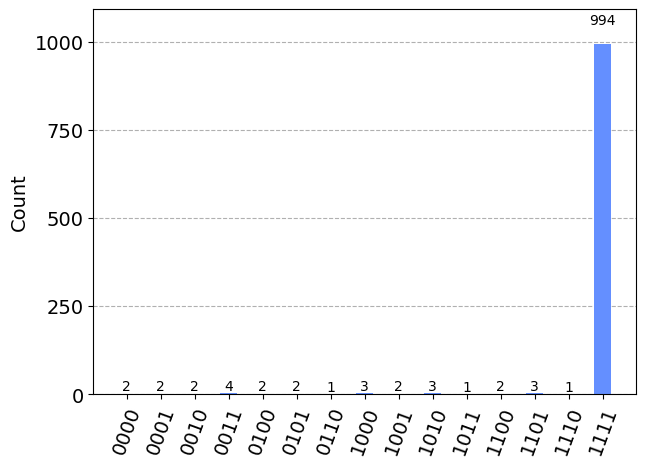

In [8]:
display(plot_histogram(counts))

Print the value with the largest count number.

In [9]:
largest_val = 0
value = ''

for entry in counts:
    if counts[entry] > largest_val:
        largest_val = counts[entry]
        value = entry

print(value)

1111


Since the output is in binary, we need to convert it to the decimal base for easier analysis using the function below.

In [10]:
def toInteger(val: str):

    num = 0
    val = val[::-1] # take the reverse of the string of integers  100 - 001
    for i in range(len(val)):
        if val[i] == '0':
            continue
        else:
            num += 2**i

    return num

Print the integer/decimal representation of the result.

In [11]:
print("The estimated index from the simulator is:",toInteger(value))

The estimated index from the simulator is: 15
